In [1]:
import numpy as np
import json
import cvxpy as cp
from pathlib import Path
import matplotlib.pyplot as plt

from src.problems.utils import sample_data_for_group
from src.problems.problems import (
    _compute_consumer_optimal_solution_cvar,
    _compute_consumer_optimal_solution_mean,
    _compute_consumer_optimal_solution_min
)

(CVXPY) May 10 08:35:16 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 10 08:35:16 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [43]:
DATA_PATH_ROOT = Path("./data")

In [42]:
# load data
with open(DATA_PATH_ROOT / "amazon_predictions.npy", "rb") as f:
    REL_MATRIX = np.load(f)

with open(DATA_PATH_ROOT / "amazon_user_groups.json", "r") as f:
    GROUPS_MAP = json.load(f)

In [54]:
N_CONSUMERS = 300
N_PRODUCERS = 300
GROUP_KEY = "top_category"
K_REC = 1
SOLVER = cp.GUROBI
GAMMA = 0.1
ALPHA = 0.95

In [45]:
rel_matrix_sampled, consumer_ids, group_assignments = sample_data_for_group(
    n_consumers=N_CONSUMERS,
    n_producers=N_PRODUCERS,
    groups_map=GROUPS_MAP,
    group_key=GROUP_KEY,
    data=REL_MATRIX,
    naive_sampling=True,
    seed=42,
)

In [ ]:
min_allocations = _compute_consumer_optimal_solution_min(
    rel_matrix=rel_matrix_sampled,
    k_rec=K_REC,
    producer_max_min_utility=10,
    gamma=GAMMA,
    solver=SOLVER
)


Interrupt request received


In [55]:
mean_allocations = _compute_consumer_optimal_solution_mean(
    rel_matrix=rel_matrix_sampled,
    k_rec=K_REC,
    producer_max_min_utility=10,
    gamma=GAMMA,
    solver=SOLVER
)

In [57]:
cvar_allocations =_compute_consumer_optimal_solution_cvar(
    rel_matrix=rel_matrix_sampled,
    k_rec=K_REC,
    producer_max_min_utility=10,
    gamma=GAMMA,
    group_assignments=group_assignments,
    alpha=ALPHA,
    solver=SOLVER
)


Interrupt request received


/gpfs/home6/dseputis1/github/msc-thesis/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [48]:
# get top k indexes for rel_matrix_sampled
best_alloc = np.argsort(rel_matrix_sampled, axis=1)[:, -K_REC:]
best_alloc_vals = np.take_along_axis(rel_matrix_sampled, best_alloc, axis=1).sum(axis=1) / K_REC

In [49]:
min_vals = min_allocations[1] * rel_matrix_sampled
mean_vals = mean_allocations[1] * rel_matrix_sampled
cvar_vals = cvar_allocations[1] * rel_matrix_sampled

In [50]:
min_vals = min_vals.sum(axis=1) / 10 / best_alloc_vals
mean_vals = mean_vals.sum(axis=1) / 10 / best_alloc_vals
cvar_vals = cvar_vals.sum(axis=1) / 10 / best_alloc_vals

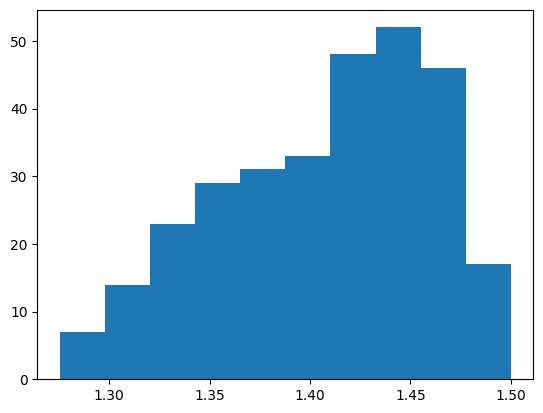

In [51]:
plt.hist(min_vals, bins=10, alpha=1, label="Min");

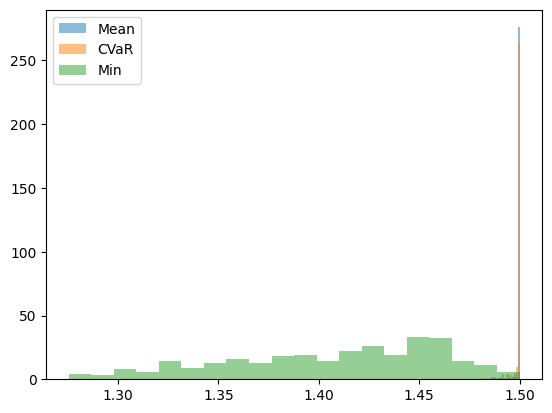

In [52]:
plt.hist(mean_vals, bins=20, alpha=0.5, label="Mean");
plt.hist(cvar_vals, bins=20, alpha=0.5, label="CVaR");
plt.hist(min_vals, bins=20, alpha=0.5, label="Min");
plt.legend()

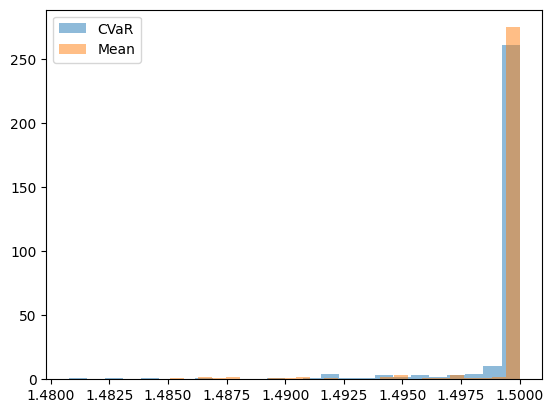

In [53]:
plt.hist(cvar_vals, bins=25, alpha=0.5, label="CVaR");
plt.hist(mean_vals, bins=25, alpha=0.5, label="Mean");
plt.legend()